/var/folders/lj/tmxb7_9119gdz2mh__v5ggt80000gn/T/ipykernel_48856/658073700.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['호선', '요일구분', '시간대'])


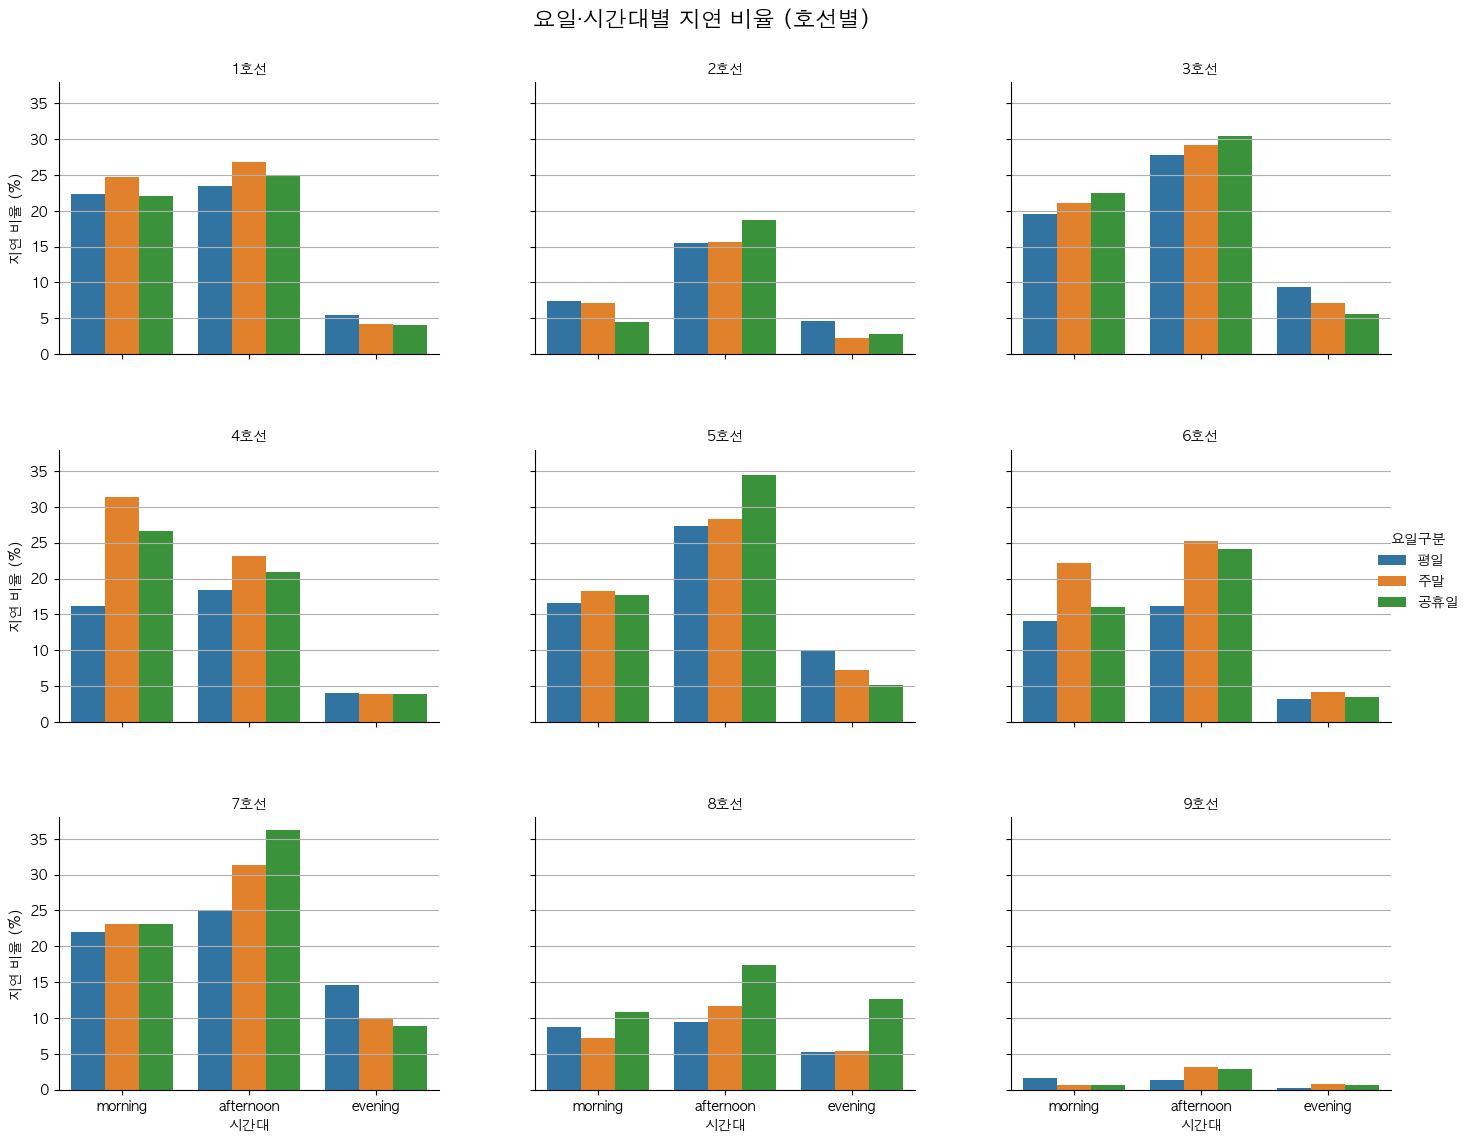

In [1]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# === 설정 ===
plt.rcParams['font.family'] = 'AppleGothic'  # macOS용 / Windows는 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

base_dir = 'data'
time_slots = ['morning', 'afternoon', 'evening']
holiday_dates = {'0603', '0606'}
year = 2025

# === 1. 데이터 통합 ===
all_records = []

for date in sorted(os.listdir(base_dir)):
    if not date.isdigit():
        continue
    for time in time_slots:
        path = f'{base_dir}/{date}/delay_{date}_{time}.csv'
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path, parse_dates=['예정시간', '실제시간'])
        df['날짜'] = date
        df['시간대'] = time

        dt = datetime.strptime(f'{year}{date}', '%Y%m%d')
        weekday = dt.weekday()
        if date in holiday_dates:
            df['요일구분'] = '공휴일'
        elif weekday < 5:
            df['요일구분'] = '평일'
        else:
            df['요일구분'] = '주말'

        all_records.append(df)

all_df = pd.concat(all_records, ignore_index=True)

# === 2. 지연 여부 플래그 + 카테고리 정리
all_df['지연여부'] = all_df['지연시간(분)'] >= 1

시간대_순서 = ['morning', 'afternoon', 'evening']
요일_순서 = ['평일', '주말', '공휴일']

all_df['시간대'] = pd.Categorical(all_df['시간대'], categories=시간대_순서, ordered=True)
all_df['요일구분'] = pd.Categorical(all_df['요일구분'], categories=요일_순서, ordered=True)

# === 3. 호선별 요일-시간대별 통계 ===
line_time_stats = (
    all_df
    .groupby(['호선', '요일구분', '시간대'])
    .agg(지연횟수=('지연여부', 'sum'),
         전체횟수=('지연여부', 'count'),
         평균지연=('지연시간(분)', 'mean'),
         지연된평균지연=('지연시간(분)', lambda x: x[x >= 1].mean()))
    .reset_index()
)

line_time_stats['지연비율(%)'] = (line_time_stats['지연횟수'] / line_time_stats['전체횟수']) * 100

import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn catplot
g = sns.catplot(
    data=line_time_stats,
    x='시간대',
    y='지연비율(%)',
    hue='요일구분',
    col='호선',
    kind='bar',
    col_wrap=3,
    height=4,
    aspect=1.2
)

# 제목과 축 설정
g.set_titles("{col_name}호선")
g.fig.suptitle("요일·시간대별 지연 비율 (호선별)", fontsize=16)

g.set_axis_labels("시간대", "지연 비율 (%)")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=0)
    ax.grid(True, axis='y')

# ✅ 레이아웃 보정: 여백 늘리기
g.fig.subplots_adjust(top=0.92, bottom=0.08, left=0.08, right=0.95, hspace=0.35, wspace=0.25)

plt.show()


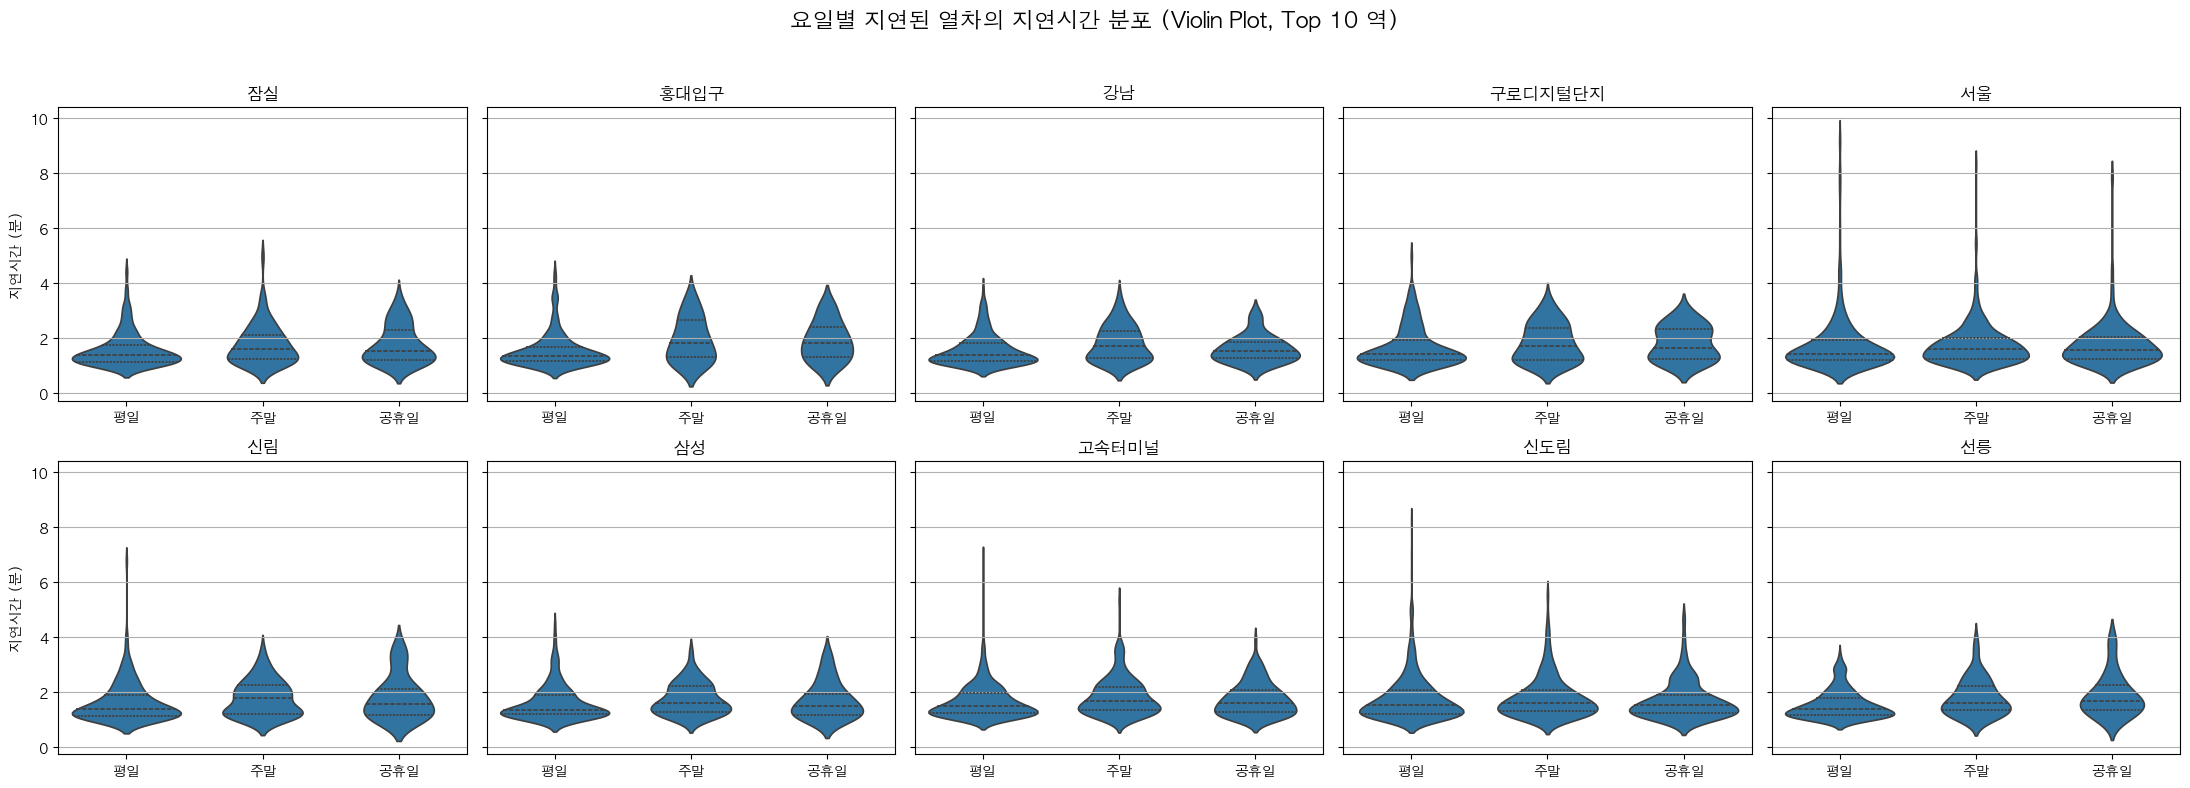

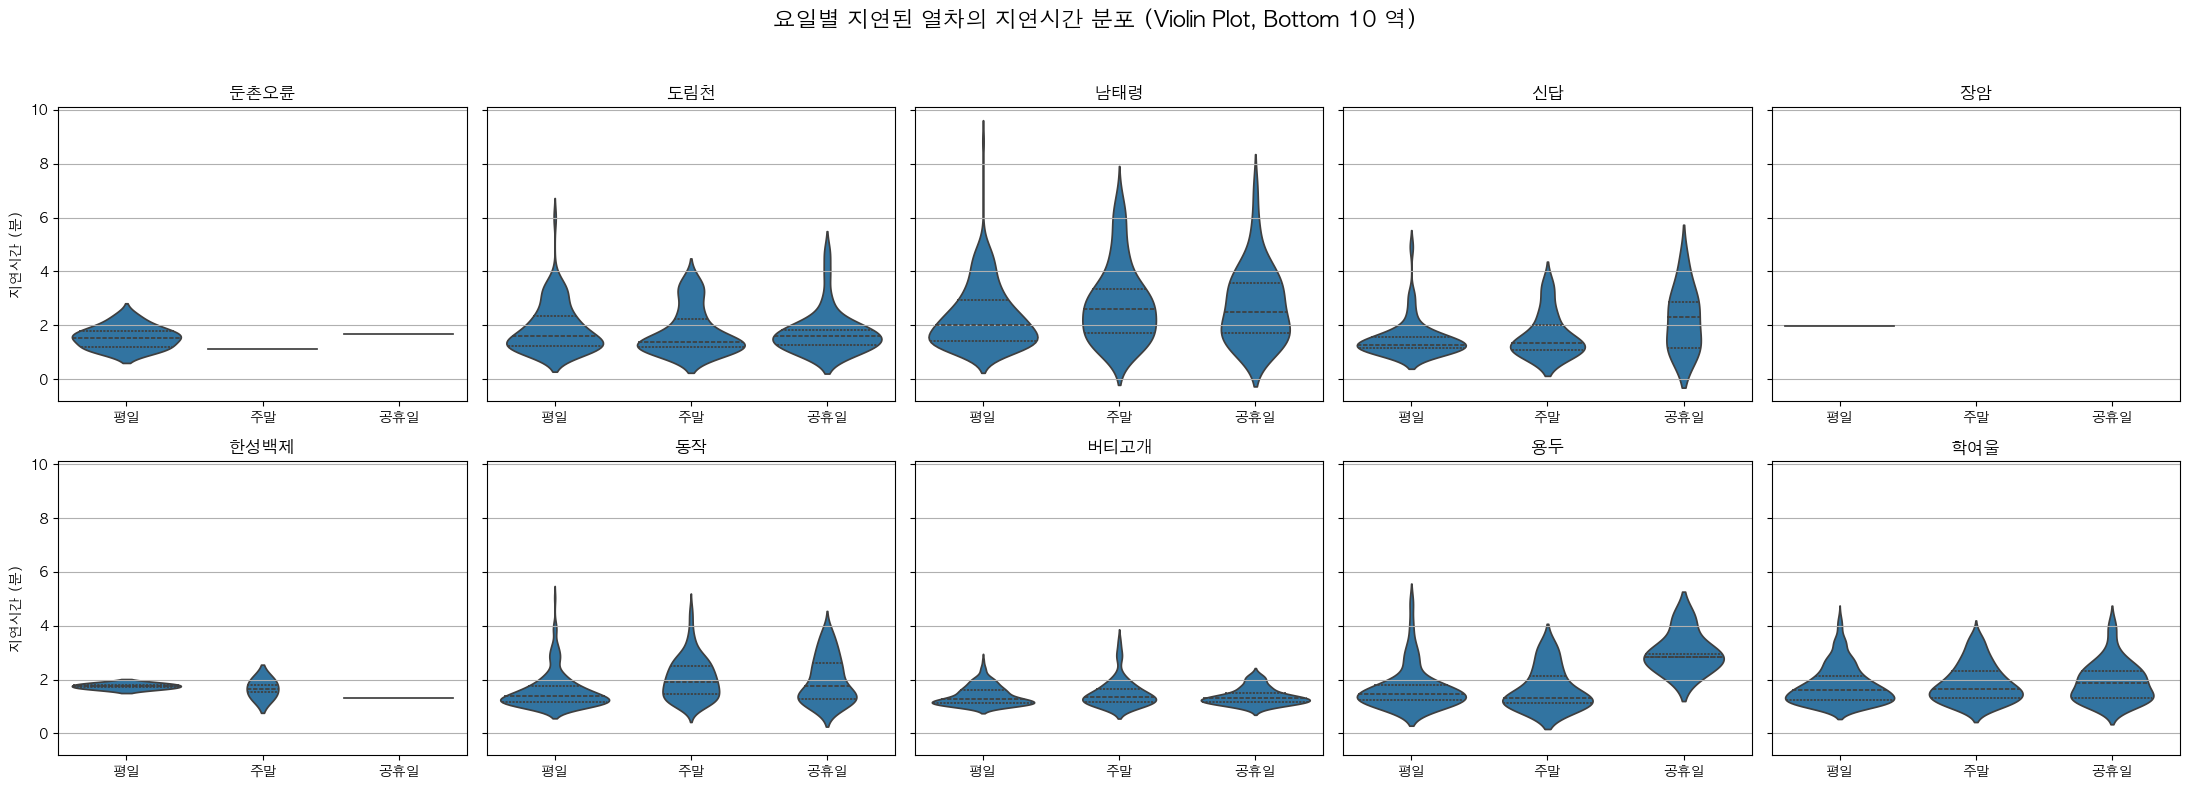

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False

# 1. 지연된 열차만 필터링
df_violin = all_df[all_df['지연시간(분)'] >= 1]

# 2. 상위/하위 10개 역사
top10_stations = ['잠실', '홍대입구', '강남', '구로디지털단지', '서울', '신림', '삼성', '고속터미널', '신도림', '선릉']
bottom10_stations = ['둔촌오륜', '도림천', '남태령', '신답', '장암', '한성백제', '동작', '버티고개', '용두', '학여울']

# === Top 10 시각화 ===
fig, axes = plt.subplots(2, 5, figsize=(22, 8), sharey=True)
axes = axes.flatten()

for i, station in enumerate(top10_stations):
    ax = axes[i]
    subset = df_violin[df_violin['역사명'] == station]
    
    sns.violinplot(data=subset, x='요일구분', y='지연시간(분)', inner='quartile', ax=ax)
    ax.set_title(station)
    ax.set_xlabel('')
    ax.set_ylabel('지연시간 (분)' if i % 5 == 0 else '')
    ax.grid(True, axis='y')

plt.suptitle("요일별 지연된 열차의 지연시간 분포 (Violin Plot, Top 10 역)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# === Bottom 10 시각화 ===
fig, axes = plt.subplots(2, 5, figsize=(22, 8), sharey=True)
axes = axes.flatten()

for i, station in enumerate(bottom10_stations):
    ax = axes[i]
    subset = df_violin[df_violin['역사명'] == station]
    
    sns.violinplot(data=subset, x='요일구분', y='지연시간(분)', inner='quartile', ax=ax)
    ax.set_title(station)
    ax.set_xlabel('')
    ax.set_ylabel('지연시간 (분)' if i % 5 == 0 else '')
    ax.grid(True, axis='y')

plt.suptitle("요일별 지연된 열차의 지연시간 분포 (Violin Plot, Bottom 10 역)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()